In [1]:
import sys
sys.path.insert(0, '/Users/rdchlth9/Codes/cmtb_refactor/')
from getdatatestbed import getDataFRF
from prepdata.prepDataLib import PrepDataTools as preptools
from prepdata import inputOutput
#from prepdata import writeRunRead
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc4
import os
import f90nml
from plotting import operationalPlots
from testbedutils import fileHandling
import py2netCDF as p2nc
%matplotlib inline

In [2]:
#test
#d1 = dt.datetime(2011,8,26,0,0,0)
#d2 = dt.datetime(2011,8,27,0,0,0)
d1 = dt.datetime(2016,8,26,0,0,0)
d2 = dt.datetime(2016,8,27,0,0,0)
fname = 'test_2011'


# Grab the relevant data from the TDS 

In [3]:
go = getDataFRF.getObs(d1,d2)

In [4]:
rawWL = go.getWL()

In [5]:
rawspec = go.getWaveSpec('waverider-26m')

 Removing Duplicates from FRF 8m Array


In [6]:
rawwind = go.getWind()

## Build a time list that has constant spacing 

In [7]:
outtime = np.arange(d1,d2,dt.timedelta(minutes=30))

In [8]:
prepdata = preptools()

In [9]:
waveTimeList = preptools.timeLists(d1,d2,30*60)
wlTimeList = preptools.timeLists(d1,d2,30*60)
windTimeList = preptools.timeLists(d1,d2,30*60)

In [10]:
#_, waveTimeList, wlTimeList, _, windTimeList = prepdata.createDifferentTimeLists(d1, d2, rawspec, rawWL,
#                                                                                     rawWind=rawwind,simTs=30*60)

## Prep Waterlevel, Winds, and Spectra by averaging over respective time, frequency, or dirction dimensions

In [11]:
wl = prepdata.prep_WL(rawWL,wlTimeList)

  -- 48 WL records with 0 interpolated points


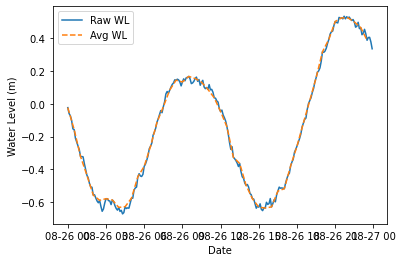

In [12]:
plt.plot(rawWL['time'],rawWL['WL'])
plt.plot(wl['time'],wl['avgWL'],'--')
plt.ylabel('Water Level (m)')
plt.xlabel('Date')
plt.legend(('Raw WL','Avg WL'))


In [13]:
wind = prepdata.prep_wind(rawwind,windTimeList,model='ww3')

  -- 48 wind records with 0 interpolated


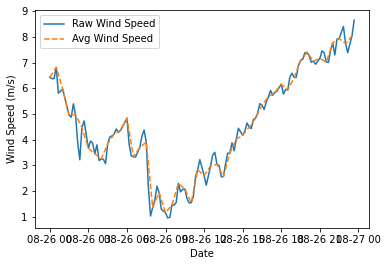

In [14]:
plt.plot(rawwind['time'],rawwind['windspeed_corrected'])
plt.plot(wind['time'],wind['avgspd'],'--')
plt.ylabel('Wind Speed (m/s)')
plt.xlabel('Date')
plt.legend(('Raw Wind Speed','Avg Wind Speed'))

In [15]:
temp = wind['avgdir'] + 180
temp[temp>360] = temp[temp>360]-360
# Need to fix this in the testbed code

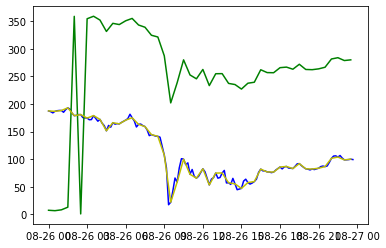

In [16]:
plt.plot(rawwind['time'],rawwind['winddir'],'b')
plt.plot(wind['time'],wind['avgdir'],'g')
plt.plot(wind['time'],temp,'y-')

In [17]:
 wavepacket = prepdata.prep_spec(rawspec, 'Base', datestr=d1.strftime('%Y-%m-%dT%H%M%SZ'), plot=False, full=True, deltaangle=10,
                                    outputPath='./', model='ww3', waveTimeList=waveTimeList)

number of wave records 48 with 0.0 interpolated points


In [18]:
print(len(wavepacket['wavefreqbin']))

35


In [19]:
goTb = getDataFRF.getDataTestBed(d1,d2)
bathy = goTb.getBathyIntegratedTransect(method=1)

Bathymetry is taken as closest in HISTORY - operational


check the f1 value for this. 

# Initilize step to write out IO for WW3 using individual calls

In [20]:
wrr = writeRunRead.ww3io(pathPrefix='/Users/rdchlth9/Codes/cmtb_refactor/data/ww3/ww3_test', fNameBase=fname+'_cmtb', versionPrefix='base',
                     startTime=d1, endTime=d2, runFlag=False,
                     generateFlag=True, readFlag=False)

TODO: Replacing parameters.... whats left can be warned at the end of this process [wrr._replaceDefaultParams]


In [21]:
if not os.path.isdir(wrr.workingDirectory):
    os.makedirs(wrr.workingDirectory)

In [22]:
 wrr.savePoints = [[-75.5947,36.2605,'P26'],[-75.7141,36.1999,'P17'],
                   [-75.7393, 36.1893,'P11'],[-75.7433,36.1883,'P08'],
                   [-75.7465,36.1873,'P06'],[-75.7482,36.1868,'P05'],
                   [-75.7487,36.1868,'P04'],[-75.7498,36.1865,'P03'],[-75.7505,36.1863,'P02']]

In [23]:
gridName = '/Users/rdchlth9/Codes/cmtb_refactor/grids/ww3/unww3_Irene_REVISED.msh'
boundName = '/Users/rdchlth9/Codes/cmtb_refactor/grids/ww3/unww3_Irene_REVISED.inbnd'
gridNodes = wrr.readWW3_msh(gridName)

In [24]:
bathyPacket = prepdata.prep_Bathy(bathy, gridNodes, unstructured=True)

## Write out files for running the model with individual calls

In [25]:
wrr.writeWW3_grid(grid_inbindfname=boundName)

In [26]:
wrr.write_msh(points=bathyPacket.points,
                           cell_data=bathyPacket.cell_data)

In [27]:
wrr.writeWW3_namelist()

In [28]:
wrr.writeWW3_spec(wavepacket)

'/Users/rdchlth9/Codes/cmtb_refactor/notebooks/ww3/data/ww3/base/test_2011_cmtb/test_2011_cmtb.nc'

In [29]:
wrr.writeWW3_speclist(ofname=os.path.join(wrr.workingDirectory,'spec.list'),specFiles=fname+'_cmtb.nc')

'/Users/rdchlth9/Codes/cmtb_refactor/notebooks/ww3/data/ww3/base/test_2011_cmtb/spec.list'

In [30]:
wrr.writeWW3_bounc(specfileListFileName='spec.list')

In [31]:
# wind and water level need to be options to include  issue 30
# cannot run with only one save point  issue 29
wrr.writeWW3_shel(d1,d2,wind,wl)

In [32]:
#
wrr.writeWW3_ounf(d1)
wrr.writeWW3_ounp(d1)

In [33]:
wrr.writeWW3_points()

## Run model external to this notebook

### Read in results

In [34]:
fieldNc = wrr.readWW3_field()
bathyout = wrr.readWW3_msh()                                                            # load bathy as input


In [35]:
fieldNc['hs'][20,:]

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=9.96921e+36,
            dtype=float32)

In [36]:
blah = nc4.date2num(nc4.num2date(fieldNc['time'][:],fieldNc['time'].units).data,'seconds since 1970-01-01')

<ipython-input-36-6b365a255d31>:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  blah = nc4.date2num(nc4.num2date(fieldNc['time'][:],fieldNc['time'].units).data,'seconds since 1970-01-01')


In [37]:
out = {'time':            nc4.date2num(nc4.num2date(fieldNc['time'][:],fieldNc['time'].units).data,'seconds since 1970-01-01'),
        'latitude':        fieldNc['latitude'][:],
        'longitude':       fieldNc['longitude'][:],
        'meshName':        -999,
        'connectivity':    fieldNc['tri'][:],
        'three':           np.ones((3)) * -999,
        'nfaces':          np.arange(fieldNc['tri'].shape[0], dtype=int),
        'nnodes':          np.arange(fieldNc.dimensions['node'].size, dtype=int),
        'xFRF':            np.ones_like(fieldNc['latitude'][:]) * -999,
        'yFRF':            np.ones_like(fieldNc['latitude'][:]) * -999,
        'waveHs':          np.ma.masked_array(fieldNc['hs'][:], mask=fieldNc['hs']._FillValue),
        'bathymetry':      bathyout['points'][:,2],  # doesn't need to be expanded into time dimension
        'waveTm':          fieldNc['t02'][:],
        'waveDm':          fieldNc['dir'][:],
        'mapStatus':       fieldNc['MAPSTA'][:]
        }
#       'dynamicTimeStep': fieldNc['dtd'][:] * 60,  # convert to seconds


<ipython-input-37-5e9e4203b9e7>:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  out = {'time':            nc4.date2num(nc4.num2date(fieldNc['time'][:],fieldNc['time'].units).data,'seconds since 1970-01-01'),


In [38]:
fieldYaml = '/Users/rdchlth9/Codes/cmtb_refactor/yaml_files/waveModels/%s/base/field_globalmeta.yml' % ('ww3')  # field
varYaml = '/Users/rdchlth9/Codes/cmtb_refactor/yaml_files/waveModels/%s/field_var.yml' % ('ww3')
#fieldOfname = fileHandling.makeTDSfileStructure('/Users/rdchlth9/Codes/cmtb_refactor/notebooks/ww3/thredds', fldrArch, datestring, 'Field')
p2nc.makenc_generic('/Users/rdchlth9/Codes/cmtb_refactor/notebooks/ww3/test.nc', globalYaml=fieldYaml, varYaml=varYaml, data=out)    

/Users/rdchlth9/anaconda3/envs/cmtb/lib/python3.8/site-packages/netCDF4/utils.py:82: RuntimeWarning: overflow encountered in multiply
  datout = np.around(scale*data)/scale
/Users/rdchlth9/Codes/cmtb_refactor/py2netCDF.py:314: UserWarning: WARNING: valid_min cannot be safely cast to variable dtype
  setattr(new_var, attr, template_vars[var][attr])
/Users/rdchlth9/Codes/cmtb_refactor/py2netCDF.py:314: UserWarning: WARNING: valid_max cannot be safely cast to variable dtype
  setattr(new_var, attr, template_vars[var][attr])


In [39]:
ncfile = nc4.Dataset('/Users/rdchlth9/Codes/cmtb_refactor/notebooks/ww3/test.nc')
variables = ncfile.variables.keys()
for var in variables:
    plotOutFname = 'test.png'
    operationalPlots.unstructuredSpatialPlot(plotOutFname, fieldNc=ncfile, variable='waveHs',timeIdx=25)

AttributeError: NetCDF: Attribute not found

In [36]:
point = wrr.readWW3_point()

In [38]:
operationalPlots.plotUnstructField('test.png',field)

AttributeError: NetCDF: Attribute not found

In [37]:
hs = field['hs']
hsval = hs[:,:]
hsval[hsval == hs._FillValue] = 0.0
np.max(hsval[40,:])

1.6804755

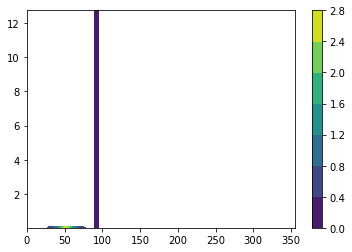

In [38]:
plt.contourf(point['direction'][:],point['frequency'][:],point['efth'][20,0,:,:])
plt.colorbar()

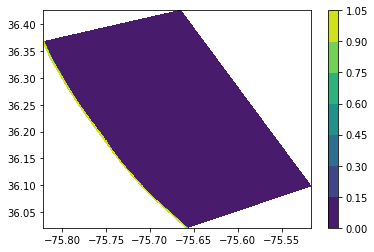

In [39]:
plt.tricontourf(field['longitude'][:],field['latitude'][:],np.max(hsval.mask,axis=0))
plt.colorbar()

## run code through CMTB functions

In [40]:
from testbedutils import fileHandling

In [41]:
wrr.workingDirectory = wrr.workingDirectory + '_full'

In [42]:
fileHandling.makeCMTBfileStructure(wrr.workingDirectory)

simulation input/output files and plots will be place in /Users/rdchlth9/Codes/cmtb_refactor/notebooks/ww3/data/ww3/base/test_2011_cmtb_full folder


In [43]:
wrrfull = writeRunRead.ww3io(pathPrefix='/Users/rdchlth9/Codes/cmtb_refactor/data/ww3/ww3_test', fNameBase=fname+'_cmtb_full', versionPrefix='base',
                     startTime=d1, endTime=d2, runFlag=False,
                     generateFlag=True, readFlag=False)

TODO: Replacing parameters.... whats left can be warned at the end of this process [wrr._replaceDefaultParams]


In [44]:
wrrfull.savePoints = wrr.savePoints

In [45]:
wrrfull.writeAllFiles(wavepacket, wind, wl, bathyPacket,gridName)

TODO: Replacing parameters.... whats left can be warned at the end of this process [wrr._replaceDefaultParams]
writing all ww3 input files 
